# Generative Adversarial Networks com o dataset MedNIST

Utilização de MONAI para a formação de uma rede para gerar imagens a partir de um tensor de entrada aleatório. Uma simples GAN é utilizada para atuar com redes separadas de Gerador e Discriminador.

Isto irá passar pelas etapas de:
* Carregar os dados a partir de uma fonte remota
* Construção de um conjunto de dados a partir destes dados e transformá-los
* Definir as redes
* Treino e avaliação

imports

In [2]:
!pip install monai

     ---------------------------------------- 1.2/1.2 MB 3.4 MB/s eta 0:00:00


In [3]:
#monai e matplotlib já instalados
import io
import os
import tarfile
import urllib

import IPython
import matplotlib.pyplot as plt
import torch

from monai.config import print_config
from monai.data import CacheDataset
from monai.networks import normal_init
from monai.networks.nets import Discriminator, Generator
from monai.transforms import (
    AddChannel,
    Compose,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
    Transform,
)
from monai.utils import progress_bar, set_determinism

print_config()

MONAI version: 1.1.0
Numpy version: 1.24.2
Pytorch version: 2.0.0+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: c:\Users\jpmag\.conda\envs\ap\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.5.0
Tensorboard version: 2.10.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.1+cpu
tqdm version: NOT INSTALLED or UNKNOWN VERSION.
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.0.0
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependenci

Definição do treino determinístico para reprodutbilidade
> Desligando isto, começará o estado aleatório do notebook em algum estado arbitrário; estabelecendo a seed dará reprodutibilidade para transformações aleatórias entre corridas.

In [4]:
set_determinism(seed=0)

Definição das variáveis de treino

In [25]:
disc_train_interval = 1
disc_train_steps = 5
batch_size = 300
latent_size = 64
num_epochs = 1
real_label = 1
gen_label = 0
learning_rate = 2e-4
betas = (0.5, 0.999)

## 1. Preparação dos Dados

#### Download do dataset
O conjunto de dados MedNIST foi recolhido a partir de vários conjuntos de [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Utilização+Políticas+e+Restrições), [o RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4) e [o conjunto de dados de raios X do tórax do NIH](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

O conjunto de dados é gentilmente disponibilizado por [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Departamento de Radiologia, Clínica Mayo) sob a licença Creative Commons [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/).

In [8]:
#constantes
MIVBOX  = False #using a container at https://mivbox.di.uminho.pt
if MIVBOX: ROOT_DIR = '../../../../../../data_sets'

In [20]:
def download_MedNIST():
    if MIVBOX:
        data_dir = os.path.join(ROOT_DIR, "MedNIST/Hand")
        hands = [os.path.join(data_dir, n) for n in os.listdir(data_dir) if ".jpeg" in n]
    else:
        #resource = "https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1"
        #remote_file = urllib.request.urlopen(resource)
        #dat = io.BytesIO(remote_file.read())
        tar = tarfile.open("MedNIST.tar.gz")
        hands = [n for n in tar.getnames() if "Hand" in n and ".jpeg" in n]
    print(f"len(hands):{len(hands)}")
    for count in range(5):
        print(hands[count])
    return hands, tar

hands, tar = download_MedNIST()

len(hands):10000
MedNIST/Hand/001498.jpeg
MedNIST/Hand/004360.jpeg
MedNIST/Hand/005988.jpeg
MedNIST/Hand/001162.jpeg
MedNIST/Hand/009552.jpeg


Para carregar os dados reais da imagem do tar file, definimos um tipo de transformação usando Matplotlib. Isto é utilizado com outras transformações para preparar os dados, seguido de transformações de aumento aleatórias. A classe `CacheDataset` é utilizada aqui para guardar todas as imagens preparadas do tarball, pelo que teremos em memória todas as imagens preparadas prontas para serem aumentadas com rotação aleatória, rotação e operações de zoom:

In [21]:
class LoadTarJpeg(Transform):
    def __call__(self, data):
        if MIVBOX: #neste caso não precisa de fazer o extract do tar
            return plt.imread(data)
        else: 
            return plt.imread(tar.extractfile(data))

train_transforms = Compose(
    [
        LoadTarJpeg(),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=15, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
    ]
)

train_ds = CacheDataset(hands, train_transforms)
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=0
)

c:\Users\jpmag\.conda\envs\ap\lib\site-packages\monai\utils\deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)
c:\Users\jpmag\.conda\envs\ap\lib\site-packages\monai\data\dataset.py:867: UserWarning: tqdm is not installed, will not show the caching progress bar.
  warnings.warn("tqdm is not installed, will not show the caching progress bar.")
c:\Users\jpmag\.conda\envs\ap\lib\site-packages\monai\utils\type_conversion.py:138: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.

### 2.1. Definir o Gerador e o Discriminador
Definimos as nossas redes geradoras e discriminatórias. Os parâmetros são cuidadosamente escolhidos para se adequarem ao tamanho da imagem de `(1, 64, 64)` como carregada a partir do ficheiro tar. As imagens de entrada para o discriminador são reduzidas quatro vezes para produzir imagens muito pequenas, que são achatadas e passadas como entrada para uma camada totalmente ligada. Os vectores latentes de entrada para o gerador são passados através de uma camada totalmente ligada para produzir uma saída da forma `(64, 8, 8)`. Esta é então subamostragem três vezes para produzir uma saída final que tem a mesma forma que as imagens reais. As redes são inicializadas com um esquema de normalização para melhorar os resultados:

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
disc_net = Discriminator(
    in_shape=(1, 64, 64),
    channels=(8, 16, 32, 64, 1),
    strides=(2, 2, 2, 2, 1),
    num_res_units=1,
    kernel_size=5,
).to(device)


gen_net = Generator(
    latent_shape=latent_size, start_shape=(64, 8, 8), channels=[32, 16, 8, 1], strides=[2, 2, 2, 1],
)

#initialize both networks
disc_net.apply(normal_init)
gen_net.apply(normal_init)

#input images are scaled to [0,1] so enforce the same of generated outputs
gen_net.conv.add_module("activation", torch.nn.Sigmoid())
gen_net = gen_net.to(device)

## 2.2. Definir as funções de perda e otimizadores
Agora definimos as funções de perda a utilizar com funções de ajuda para completar o processo de cálculo de perdas para o gerador e o discriminador. Definimos também os nossos otimizadores:

In [23]:
disc_loss = torch.nn.BCELoss()
gen_loss = torch.nn.BCELoss()

disc_opt = torch.optim.Adam(disc_net.parameters(), learning_rate, betas=betas)
gen_opt = torch.optim.Adam(gen_net.parameters(), learning_rate, betas=betas)

def discriminator_loss(gen_images, real_images):
    """
    The discriminator loss if calculated by comparing its
    prediction for real and generated images.

    """
    real = real_images.new_full((real_images.shape[0], 1), real_label)
    gen = gen_images.new_full((gen_images.shape[0], 1), gen_label)

    realloss = disc_loss(disc_net(real_images), real)
    genloss = disc_loss(disc_net(gen_images.detach()), gen)

    return (realloss + genloss) / 2

def generator_loss(input):
    """
    The generator loss is calculated by determining how well
    the discriminator was fooled by the generated images.

    """
    output = disc_net(input)
    cats = output.new_full(output.shape, real_label)
    return gen_loss(output, cats)

## 3. Treino do modelo
Agora treinamos por iteração sobre o conjunto de dados durante várias épocas. Em certos momentos após a fase de treino do gerador para cada lote, o discriminador é treinado para uma série de passos sobre as mesmas imagens reais e geradas.

In [26]:
epoch_loss_values = [(0, 0)]
gen_step_loss = []
disc_step_loss = []
step = 0

for epoch in range(num_epochs):
    gen_net.train()
    disc_net.train()
    epoch_loss = 0

    for i, batch_data in enumerate(train_loader):
        progress_msg=f"epoch {epoch + 1}, avg loss: {epoch_loss_values[-1][1]:.4f}"
        progress_bar(i, len(train_loader), progress_msg)
        
        real_images = batch_data.to(device)
        latent = torch.randn(real_images.shape[0], latent_size).to(device)

        gen_opt.zero_grad()
        gen_images = gen_net(latent)
        loss = generator_loss(gen_images)
        loss.backward()
        gen_opt.step()
        epoch_loss += loss.item()

        gen_step_loss.append((step, loss.item()))

        if step % disc_train_interval == 0:
            disc_total_loss = 0

            for _ in range(disc_train_steps):
                disc_opt.zero_grad()
                dloss = discriminator_loss(gen_images, real_images)
                dloss.backward()
                disc_opt.step()
                disc_total_loss += dloss.item()

            disc_step_loss.append((step, disc_total_loss / disc_train_steps))

        step += 1

    epoch_loss /= step
    epoch_loss_values.append((step, epoch_loss))

    IPython.display.clear_output()

Os valores de perda separados para o gerador e para o discriminador podem ser vistos em conjunto. Estes devem alcançar um equilíbrio, pois a capacidade do gerador de enganar o discriminador equilibra-se com a capacidade da rede de discriminar com precisão entre imagens reais e falsas.

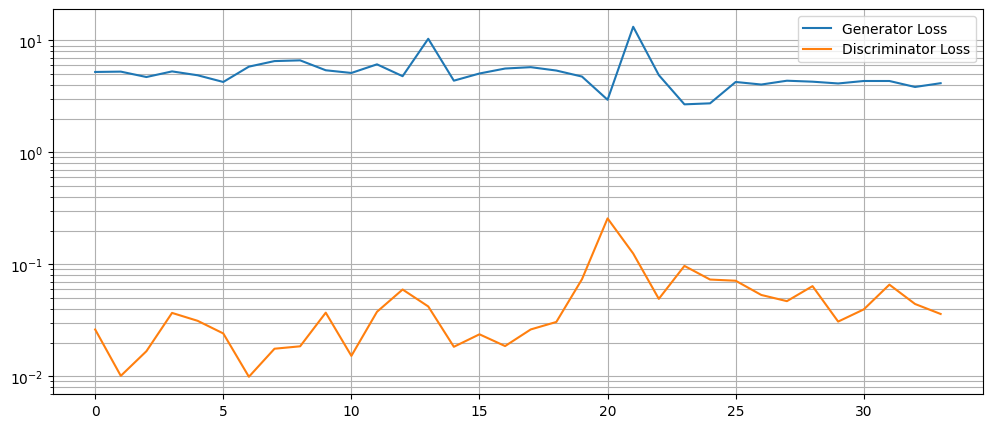

In [27]:
plt.figure(figsize=(12, 5))
plt.semilogy(*zip(*gen_step_loss), label="Generator Loss")
plt.semilogy(*zip(*disc_step_loss), label="Discriminator Loss")
plt.grid(True, "both", "both")
plt.legend()

## 4. Amostragem
Finalmente, mostramos algumas imagens geradas aleatoriamente. Esperemos que a maioria das imagens tenha quatro dedos e um polegar, como esperado (assumindo que os exemplos de polidáctilo não estavam presentes em grande número no conjunto de dados). Este notebook demonstrativo não treina as redes durante muito tempo - a formação para além das 50 épocas predefinidas deverá melhorar os resultados.

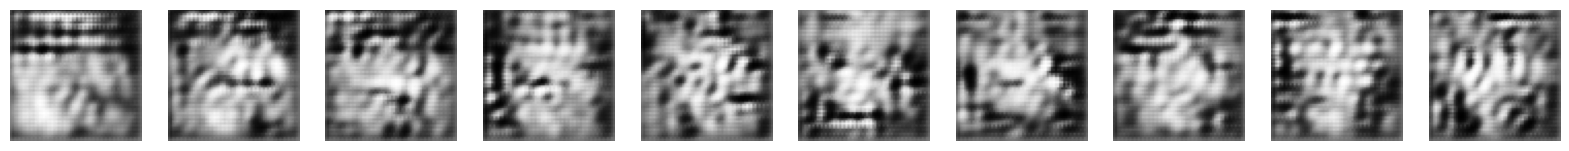

In [28]:
test_size = 10
test_latent = torch.randn(test_size, latent_size).to(device)

test_images = gen_net(test_latent)

fig, axs = plt.subplots(1, test_size, figsize=(20, 4))

for i, ax in enumerate(axs):
    ax.axis("off")
    ax.imshow(test_images[i, 0].cpu().data.numpy(), cmap="gray")